In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB, ComplementNB, CategoricalNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
import scipy.stats as st

***Get Data***

In [2]:
with open('../DataBases/CD4EncodedBase.pkl', 'rb') as f:
    columns, Cd4AttributesTrainingBalanced, Cd4ClassResultsTrainingBalanced, Cd4AttributesTest, Cd4ClassResultsTest = pickle.load(f)
with open('../Databases/VlEncodedBase.pkl', 'rb') as f:
    columns, VlAttributesTrainingBalanced, VlClassResultsTrainingBalanced, Vl4AttributesTest, VlClassResultsTest = pickle.load(f)

***GridSearch***

In [3]:
param_grid = [
    {
        'estimator': [OneVsRestClassifier(MultinomialNB())],
        'estimator__estimator__alpha': np.logspace(-3, 3, 7),
        'estimator__estimator__fit_prior': [True, False]
    },
    {
        'estimator': [OneVsRestClassifier(BernoulliNB())],
        'estimator__estimator__alpha': np.logspace(-3, 3, 7),
        'estimator__estimator__fit_prior': [True, False],
        'estimator__estimator__binarize': np.linspace(0.1, 0.9, 9)
    },
    {
        'estimator': [OneVsRestClassifier(GaussianNB())],
        'estimator__estimator__var_smoothing': np.logspace(-9,-6 ,4)
    },
    {
        'estimator': [OneVsRestClassifier(ComplementNB())],
        'estimator__estimator__alpha': np.logspace(-3, 3 ,7),
        'estimator__estimator__fit_prior': [True,False],
        'estimator__estimator__norm':[True,False]
    },
    {
        'estimator': [OneVsRestClassifier(CategoricalNB())],
        'estimator__estimator__alpha': np.logspace(-3 ,3 ,7),
    }
]

In [4]:
grid_search = GridSearchCV(estimator=OneVsRestClassifier(DummyClassifier()), param_grid=param_grid, cv=5)

In [5]:
grid_search.fit(Cd4AttributesTrainingBalanced, Cd4ClassResultsTrainingBalanced)

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=DummyClassifier()),
             param_grid=[{'estimator': [OneVsRestClassifier(estimator=MultinomialNB())],
                          'estimator__estimator__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'estimator__estimator__fit_prior': [True, False]},
                         {'estimator': [OneVsRestClassifier(estimator=BernoulliNB())],
                          'es...
                         {'estimator': [OneVsRestClassifier(estimator=ComplementNB())],
                          'estimator__estimator__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'estimator__estimator__fit_prior': [True, False],
                          'estimator__estimator__norm': [True, False]},
                         {'estimator': [OneVsRestClassifier(estimator=CategoricalNB())],
                          'estimator__estimator__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}])

In [6]:
print(grid_search.best_params_)
print(grid_search.best_score_)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

{'estimator': OneVsRestClassifier(estimator=GaussianNB(var_smoothing=1e-07)), 'estimator__estimator__var_smoothing': 1e-07}
0.670631101775744


***Perform k-fold cross-validation and evaluate best model***

In [7]:
# Perform k-fold cross-validation and calculate accuracy scores
kf = KFold(n_splits=15, shuffle=True, random_state=42)

# Create an empty list to store the metrics from each fold
accuracy = []
precision_scores_class_0 = []
precision_scores_class_1 = []
recall_scores_class_0 = []
recall_scores_class_1 = []
f1_scores_class_0 = []
f1_scores_class_1 = []

# Perform k-fold cross-validation
for train_index, val_index in kf.split(VlAttributesTrainingBalanced):
    X_train, X_val = Cd4AttributesTrainingBalanced[train_index], Cd4AttributesTrainingBalanced[val_index]
    y_train, y_val = Cd4ClassResultsTrainingBalanced[train_index], Cd4ClassResultsTrainingBalanced[val_index]

    # Fit the model on the training data
    best_model.fit(X_train, y_train)

    # Predict the labels for the validation data
    y_pred = best_model.predict(X_val)

    # Store the precision, recall, and F-measure scores for each class
    precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_pred, average=None)
    accuracy.append(accuracy_score(y_val, y_pred))

    precision_scores_class_0.append(precision[0])
    precision_scores_class_1.append(precision[1])
    recall_scores_class_0.append(recall[0])
    recall_scores_class_1.append(recall[1])
    f1_scores_class_0.append(fscore[0])
    f1_scores_class_1.append(fscore[1])

precision_avg_class_0 = np.round(np.mean(precision_scores_class_0), 3)
precision_avg_class_1 = np.round(np.mean(precision_scores_class_1), 3)
recall_avg_class_0 = np.round(np.mean(recall_scores_class_0), 3)
recall_avg_class_1 = np.round(np.mean(recall_scores_class_1), 3)
f1_avg_class_0 = np.round(np.mean(f1_scores_class_0), 3)
f1_avg_class_1 = np.round(np.mean(f1_scores_class_1), 3)
accuracy_avg = np.round(np.mean(accuracy), 3)

print("Average Precision - Class 0:", precision_avg_class_0)
print("Average Precision - Class 1:", precision_avg_class_1)
print("---------------------------------------------------")
print("Average Recall - Class 0:", recall_avg_class_0)
print("Average Recall - Class 1:", recall_avg_class_1)
print("---------------------------------------------------")
print("Average F1 Score - Class 0:", f1_avg_class_0)
print("Average F1 Score - Class 1:", f1_avg_class_1)
print("---------------------------------------------------")
print("Average Accuracy:", accuracy_avg)
print("---------------------------------------------------")

with open('../Results/Cd4Naive.pkl', 'wb') as f:
    pickle.dump([accuracy], f)

Average Precision - Class 0: 0.642
Average Precision - Class 1: 0.683
---------------------------------------------------
Average Recall - Class 0: 0.485
Average Recall - Class 1: 0.805
---------------------------------------------------
Average F1 Score - Class 0: 0.551
Average F1 Score - Class 1: 0.739
---------------------------------------------------
Average Accuracy: 0.671
---------------------------------------------------


***Executing Naive Bayes***

In [8]:
nab = best_model
model = nab.fit(Cd4AttributesTrainingBalanced, Cd4ClassResultsTrainingBalanced)

***Confidence interval***

In [9]:
#Function for calculating confidence interval from cross-validation
def interval_confidence(values):
    return st.t.interval(confidence=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    
# Calculate confidence intervals for precision, recall, and F1 scores of each class
precision_ci_class_0 = interval_confidence(np.array(precision_scores_class_0))
precision_ci_class_1 = interval_confidence(np.array(precision_scores_class_1))
recall_ci_class_0 = interval_confidence(np.array(recall_scores_class_0))
recall_ci_class_1 = interval_confidence(np.array(recall_scores_class_1))
fscore_ci_class_0 = interval_confidence(np.array(f1_scores_class_0))
fscore_ci_class_1 = interval_confidence(np.array(f1_scores_class_1))
accuracy_ci = interval_confidence(np.array(accuracy))

# Print confidence intervals for each class
print("95% Confidence Interval - Precision - Class 0:")
print(precision_ci_class_0)
print("---------------------------------------------------")
print("95% Confidence Interval - Precision - Class 1:")
print(precision_ci_class_1)
print("---------------------------------------------------")
print("95% Confidence Interval - Recall - Class 0:")
print(recall_ci_class_0)
print("---------------------------------------------------")
print("95% Confidence Interval - Recall - Class 1:")
print(recall_ci_class_1)
print("---------------------------------------------------")
print("95% Confidence Interval - F1 Score - Class 0:")
print(fscore_ci_class_0)
print("---------------------------------------------------")
print("95% Confidence Interval - F1 Score - Class 1:")
print(fscore_ci_class_1)
print("---------------------------------------------------")
print("95% Confidence Interval - Accuracy:")
print(accuracy_ci)


95% Confidence Interval - Precision - Class 0:
(0.615182131547501, 0.6682938922787178)
---------------------------------------------------
95% Confidence Interval - Precision - Class 1:
(0.6592507534765008, 0.7069365343770347)
---------------------------------------------------
95% Confidence Interval - Recall - Class 0:
(0.4592991055142354, 0.5097406838891191)
---------------------------------------------------
95% Confidence Interval - Recall - Class 1:
(0.7938722271761757, 0.8167687881778424)
---------------------------------------------------
95% Confidence Interval - F1 Score - Class 0:
(0.5280810499986793, 0.574447314769638)
---------------------------------------------------
95% Confidence Interval - F1 Score - Class 1:
(0.7218091279916183, 0.7552663310079939)
---------------------------------------------------
95% Confidence Interval - Accuracy:
(0.6536595361758986, 0.687364722584209)


***Metrics***

              precision    recall  f1-score   support

           0       0.68      0.57      0.62       667
           1       0.73      0.80      0.76       936

    accuracy                           0.71      1603
   macro avg       0.70      0.69      0.69      1603
weighted avg       0.70      0.71      0.70      1603



c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


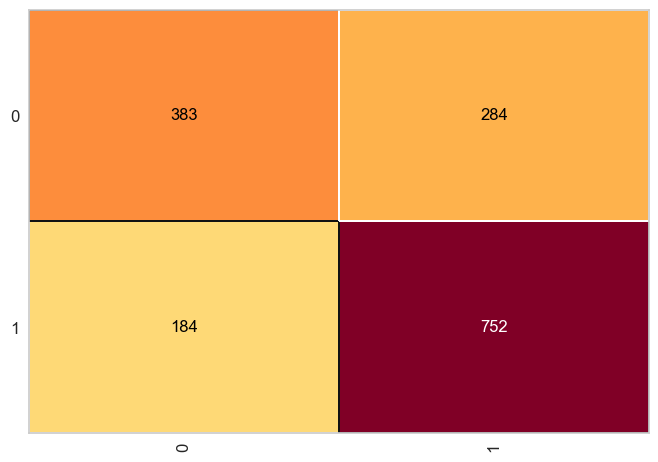

In [10]:
from sklearn.metrics import confusion_matrix

cm = ConfusionMatrix(model)
cm.score(Cd4AttributesTest, Cd4ClassResultsTest)
y_pred = model.predict(Cd4AttributesTest)
report = classification_report(Cd4ClassResultsTest, y_pred)
print(report)

***Confidence Interval***

In [11]:
class_0_precision_confidence_interval = st.t.interval(confidence=0.95, df=len(precision_scores_class_0)-1, loc=np.mean(precision_scores_class_0), scale=st.sem(precision_scores_class_0))
class_1_precision_confidence_interval = st.t.interval(confidence=0.95, df=len(precision_scores_class_1)-1, loc=np.mean(precision_scores_class_1), scale=st.sem(precision_scores_class_1))
class_0_recall_confidence_interval = st.t.interval(confidence=0.95, df=len(recall_scores_class_0)-1, loc=np.mean(recall_scores_class_0), scale=st.sem(recall_scores_class_0))
class_1_recall_confidence_interval = st.t.interval(confidence=0.95, df=len(recall_scores_class_1)-1, loc=np.mean(recall_scores_class_1), scale=st.sem(recall_scores_class_1))
class_0_f1_confidence_interval = st.t.interval(confidence=0.95, df=len(f1_scores_class_0)-1, loc=np.mean(f1_scores_class_0), scale=st.sem(f1_scores_class_0))
class_1_f1_confidence_interval = st.t.interval(confidence=0.95, df=len(f1_scores_class_1)-1, loc=np.mean(f1_scores_class_1), scale=st.sem(f1_scores_class_1))
print("95% Confidence Interval for Precision (Class 0):", class_0_precision_confidence_interval)
print("95% Confidence Interval for Precision (Class 1):", class_1_precision_confidence_interval)
print("95% Confidence Interval for Recall (Class 0):", class_0_recall_confidence_interval)
print("95% Confidence Interval for Recall (Class 1):", class_1_recall_confidence_interval)
print("95% Confidence Interval for F1 (Class 0):", class_0_f1_confidence_interval)
print("95% Confidence Interval for F1 (Class 1):", class_1_f1_confidence_interval)

95% Confidence Interval for Precision (Class 0): (0.615182131547501, 0.6682938922787178)
95% Confidence Interval for Precision (Class 1): (0.6592507534765008, 0.7069365343770347)
95% Confidence Interval for Recall (Class 0): (0.4592991055142354, 0.5097406838891191)
95% Confidence Interval for Recall (Class 1): (0.7938722271761757, 0.8167687881778424)
95% Confidence Interval for F1 (Class 0): (0.5280810499986793, 0.574447314769638)
95% Confidence Interval for F1 (Class 1): (0.7218091279916183, 0.7552663310079939)
